In [1]:
import os
import tensorflow as tf
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input

from keras.applications import VGG19
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras import regularizers
from keras.models import Model, load_model

from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import pandas as pd

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [11]:
train_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/AffectNet Resize/train 7/'
validation_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/AffectNet Resize/test 7/'

In [12]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
CHANNELS = 3
num_classes = 7

batch_size=32*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)
class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [13]:
# Init the Image Data Generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train Images
train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
)

# Validation images (From Train Images)
validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'
)

Found 22221 images belonging to 7 classes.
Found 5545 images belonging to 7 classes.


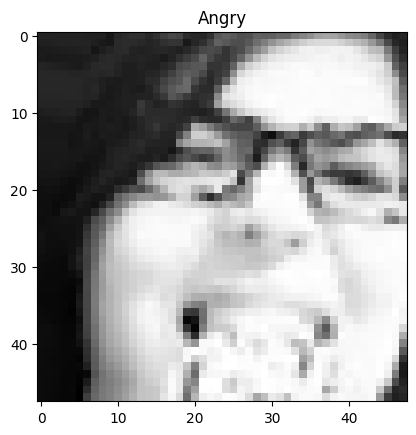

In [14]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [15]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,anger,disgust,fear,happy,neutral,sad,surprise
train,2910,2093,2897,4036,4105,2744,3436
test,721,520,724,1009,1026,686,859


In [16]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

22221
5545


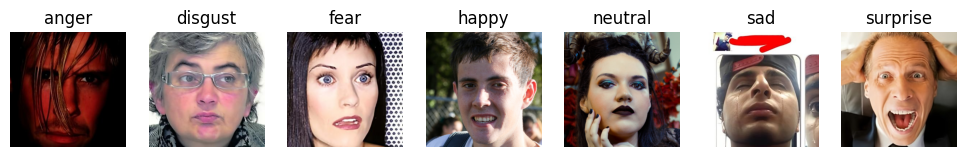

In [17]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Training Dependencies

In [18]:
# Compute the class weights
class_to_idx=validation_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(class_weights)


# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
{0: 1.4106529209621994, 1: 1.961299569995222, 2: 1.4169830859509838, 3: 1.0170961347869176, 4: 1.0, 5: 1.4959912536443147, 6: 1.1947031431897555}


In [19]:
with strategy.scope():

    # Load the VGG19 model
    base_model = VGG19(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x) 
    predictions = Dense(7, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           

In [20]:
# Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=30,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/j

In [22]:
save_model = model.save('VGG19_TL_70e_AffectNet_7emotions.h5')

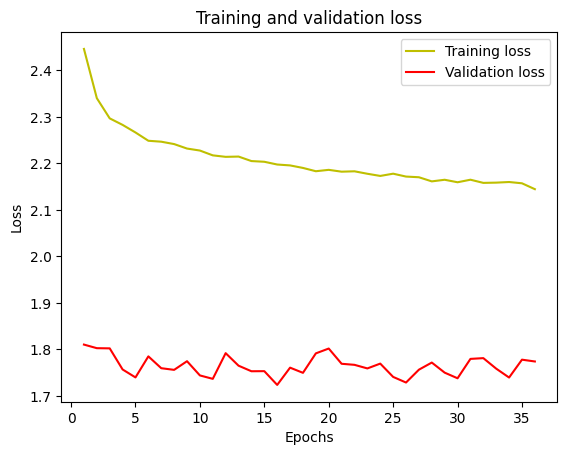

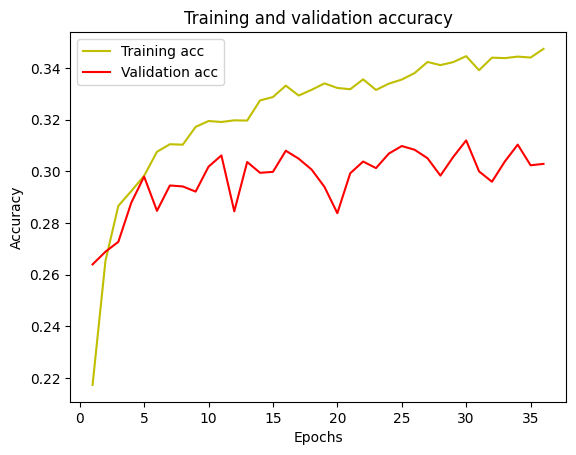

In [23]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 117ms/step
Accuracy =  0.34375


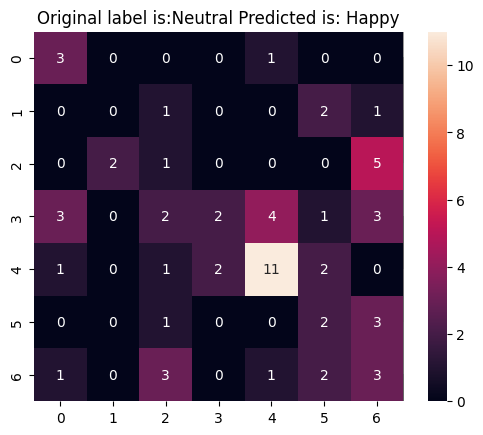

In [24]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Model Evaluation

Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
2/2 [==============================] - 0s 48ms/step
Accuracy =  0.46875


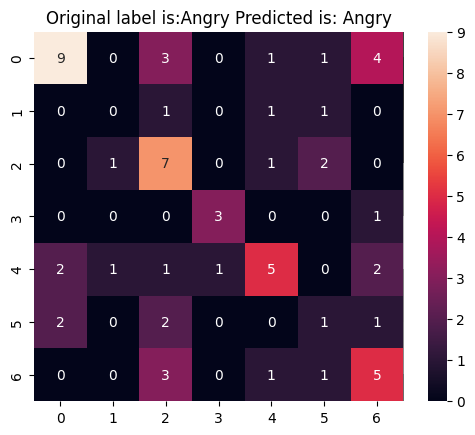

2/2 [==============================] - 0s 49ms/step
Accuracy =  0.1875


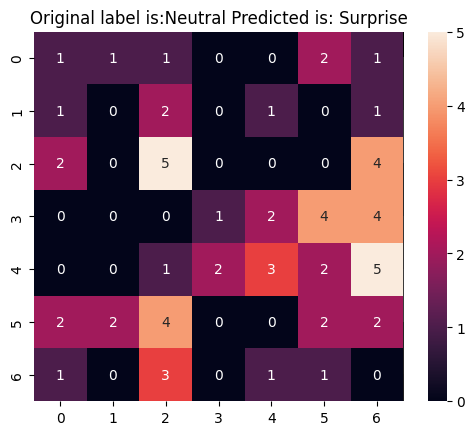

In [17]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [18]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.3031


In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 49ms/step
Accuracy: 30.305232558139533
anger 715/5557 acc: 42.9
disgust 529/5557 acc: 9.5
fear 716/5557 acc: 38.7
happy 1002/5557 acc: 16.6
neutral 1012/5557 acc: 43.7
sad 681/5557 acc: 18.2
surprise 849/5557 acc: 35.6


In [20]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 30.305232558139533
anger 715/5557 acc: 42.9
disgust 529/5557 acc: 9.5
fear 716/5557 acc: 38.7
happy 1002/5557 acc: 16.6
neutral 1012/5557 acc: 43.7
sad 681/5557 acc: 18.2
surprise 849/5557 acc: 35.6


              precision    recall  f1-score   support

       anger       0.30      0.43      0.35       715
     disgust       0.17      0.09      0.12       529
        fear       0.26      0.39      0.31       716
       happy       0.47      0.17      0.24      1002
     neutral       0.40      0.44      0.42      1012
         sad       0.22      0.18      0.20       681
    surprise       0.27      0.36      0.31       849

    accuracy                           0.30      5504
   macro avg       0.30      0.29      0.28      5504
weighted avg       0.32      0.30      0.29      5504



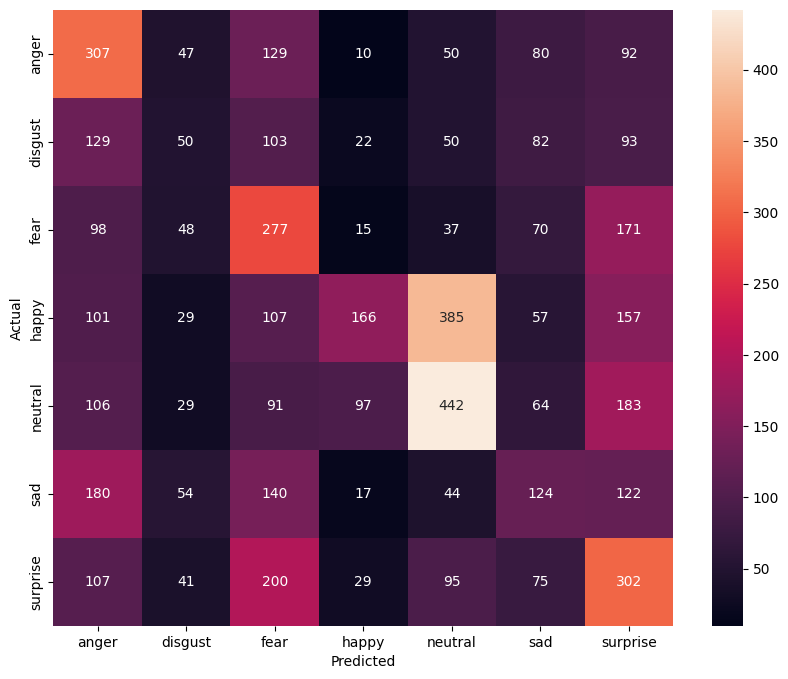

In [21]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with images

In [30]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 2s 2s/step
Predicted emotion class: happy, probability: 0.5014618039131165
1/1 [==============================] - 0s 99ms/step
Predicted emotion class: surprise, probability: 0.8765483498573303
1/1 [==============================] - 0s 99ms/step
Predicted emotion class: surprise, probability: 0.9350074529647827
1/1 [==============================] - 0s 97ms/step
Predicted emotion class: happy, probability: 0.3069123923778534
1/1 [==============================] - 0s 99ms/step
Predicted emotion class: happy, probability: 0.3721332848072052
1/1 [==============================] - 0s 112ms/step
Predicted emotion class: happy, probability: 0.34321367740631104
1/1 [==============================] - 0s 101ms/step
Predicted emotion class: neutral, probability: 0.6306641101837158
1/1 [==============================] - 0s 113ms/step
Predicted emotion class: sad, probability: 0.29236581921577454
1/1 [==============================] - 0s 126ms/step
Predicted 

# Unseen batch

In [25]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [26]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


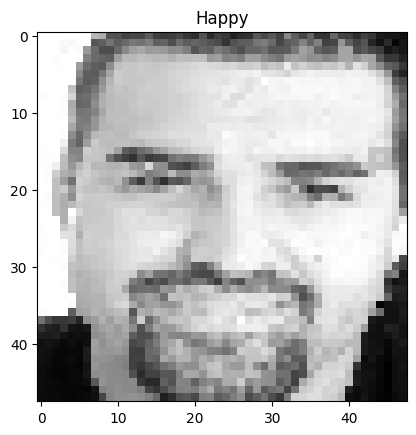

In [27]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
Best batch saved
Best batch saved
2/2 [==============================] - 0s 48ms/step
Accuracy =  0.34375


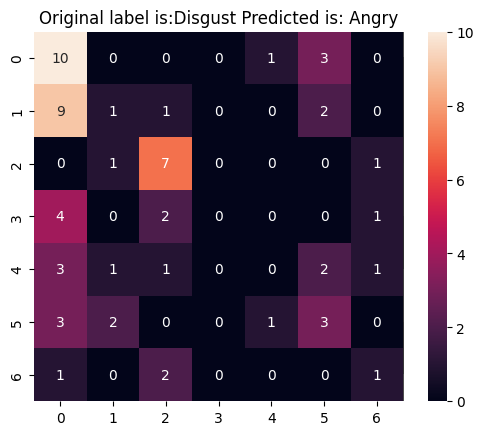

2/2 [==============================] - 0s 35ms/step
Accuracy =  0.09375


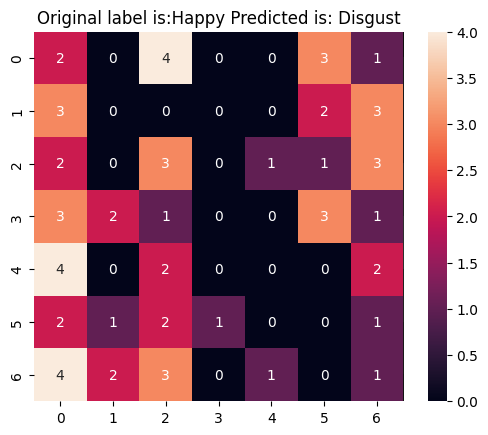

In [28]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry', 'Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry', 'Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [29]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.2349


In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 47ms/step
Accuracy: 23.486328125
Angry 297/2100 acc: 45.1
Disgust 292/2100 acc: 11.0
Fear 291/2100 acc: 39.9
Happy 293/2100 acc: 3.1
Neutral 293/2100 acc: 1.4
Sad 294/2100 acc: 30.3
Surprise 288/2100 acc: 33.7


# Accuracy global and per class

In [31]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 23.486328125
Angry 297/2100 acc: 45.1
Disgust 292/2100 acc: 11.0
Fear 291/2100 acc: 39.9
Happy 293/2100 acc: 3.1
Neutral 293/2100 acc: 1.4
Sad 294/2100 acc: 30.3
Surprise 288/2100 acc: 33.7


              precision    recall  f1-score   support

       Angry       0.19      0.45      0.27       297
     Disgust       0.29      0.11      0.16       292
        Fear       0.27      0.40      0.32       291
       Happy       0.43      0.03      0.06       293
     Neutral       0.06      0.01      0.02       293
         Sad       0.21      0.30      0.25       294
    Surprise       0.33      0.34      0.34       288

    accuracy                           0.23      2048
   macro avg       0.25      0.23      0.20      2048
weighted avg       0.25      0.23      0.20      2048



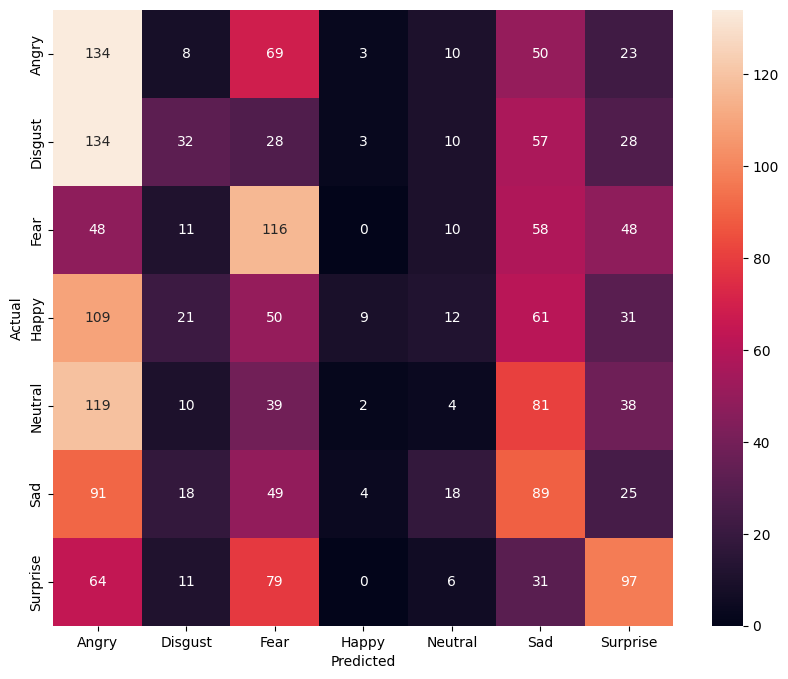

In [32]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Fine Tunning

In [21]:
with strategy.scope():

    model = load_model('best_model.h5')
    
    # # Load the VGG19 model
    # base_model = VGG16(
    #     weights='imagenet', 
    #     include_top=False, 
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    for layer in model.layers:
        layer.trainable = True
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    # inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # x = base_model(inputs)
    # x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x) 
    # predictions = Dense(7, activation='softmax')(x)

    # # Compile the model
    # model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903   

In [22]:
    # Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=200,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = hierarchical_copy, num_packs = 1
347/347 [==============================] - ETA: 0s - loss: 2.2947 - accuracy: 0.2680
Epoch 1: val_accuracy did not improve from 0.33957
347/347 [==============================] - 58s 150ms/step - loss: 2.2947 - accuracy: 0.2680 - val_loss: 1.5958 - val_accuracy: 0.3265 - lr: 1.0000e-04
Epoch 2/200
347/347 [==============================] - ETA: 0s - loss: 1.8961 - accuracy: 0.4252
Epoch 2: val_accuracy improved from 0.33957 to 0.50218, saving model to best_model.h5
347/347 [==============================] - 52s 150ms/step - loss: 1.8961 - accuracy: 0.4252 - val_loss: 1.2317 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 3/200
347/347 [==============================] - ETA: 0s - loss: 1.7472 - accuracy: 0.4851
Epoch 3: val_accuracy did not improve from 0.50218
347/347 [============

In [23]:
save_model = model.save('VGG19_TL_FT_100e_AffectNet_7emotions.h5')

# Fine Tunning model evaluation

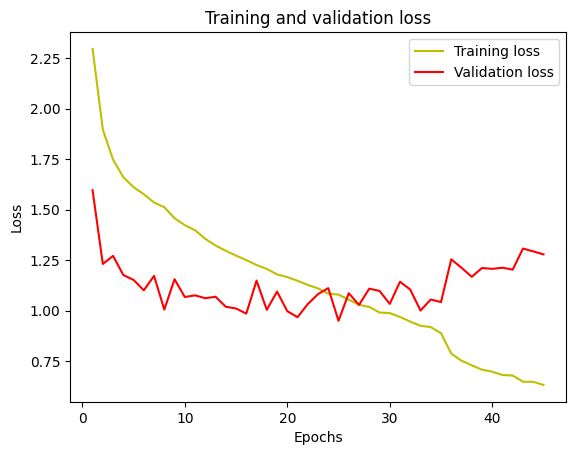

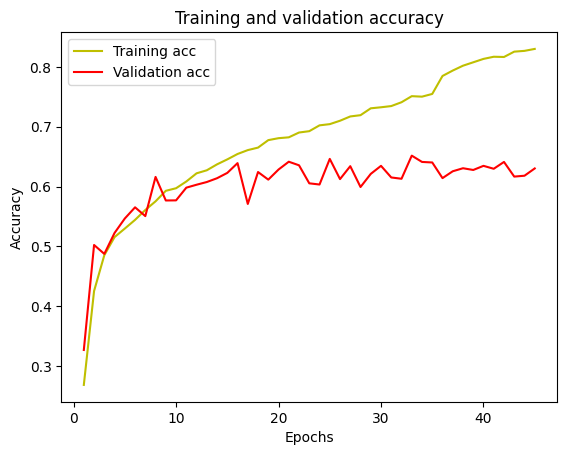

In [24]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 2s 10ms/step
Accuracy =  0.609375


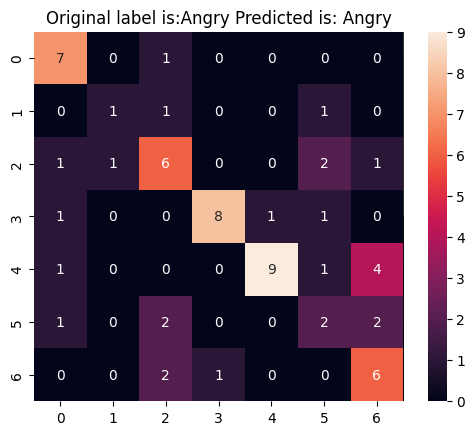

In [25]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 43ms/step
Accuracy =  0.765625


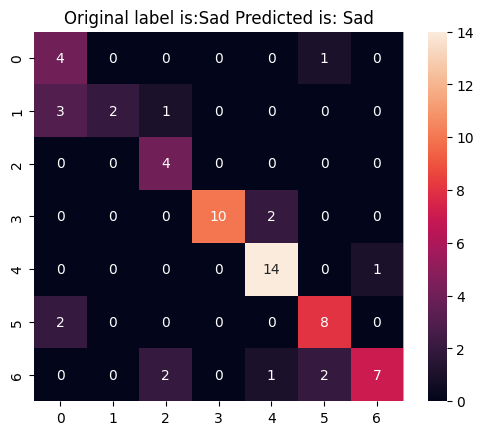

2/2 [==============================] - 0s 42ms/step
Accuracy =  0.453125


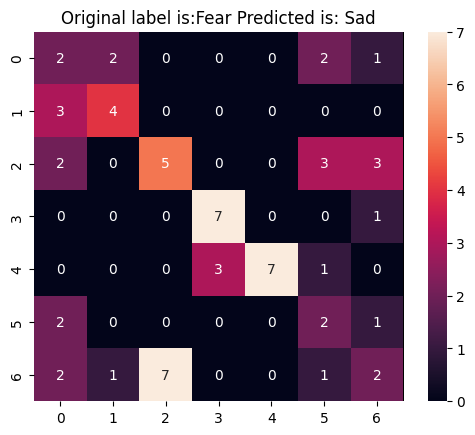

In [26]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [27]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.6306


In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 43ms/step
Accuracy: 63.06322674418605
anger 714/5545 acc: 63.0
disgust 519/5545 acc: 48.0
fear 720/5545 acc: 56.8
happy 1002/5545 acc: 84.7
neutral 1017/5545 acc: 69.2
sad 683/5545 acc: 59.7
surprise 849/5545 acc: 47.3


In [29]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 63.06322674418605
anger 714/5545 acc: 63.0
disgust 519/5545 acc: 48.0
fear 720/5545 acc: 56.8
happy 1002/5545 acc: 84.7
neutral 1017/5545 acc: 69.2
sad 683/5545 acc: 59.7
surprise 849/5545 acc: 47.3


              precision    recall  f1-score   support

       anger       0.47      0.63      0.54       714
     disgust       0.46      0.48      0.47       519
        fear       0.51      0.57      0.54       720
       happy       0.92      0.85      0.88      1002
     neutral       0.85      0.69      0.76      1017
         sad       0.49      0.60      0.54       683
    surprise       0.66      0.47      0.55       849

    accuracy                           0.63      5504
   macro avg       0.62      0.61      0.61      5504
weighted avg       0.66      0.63      0.64      5504



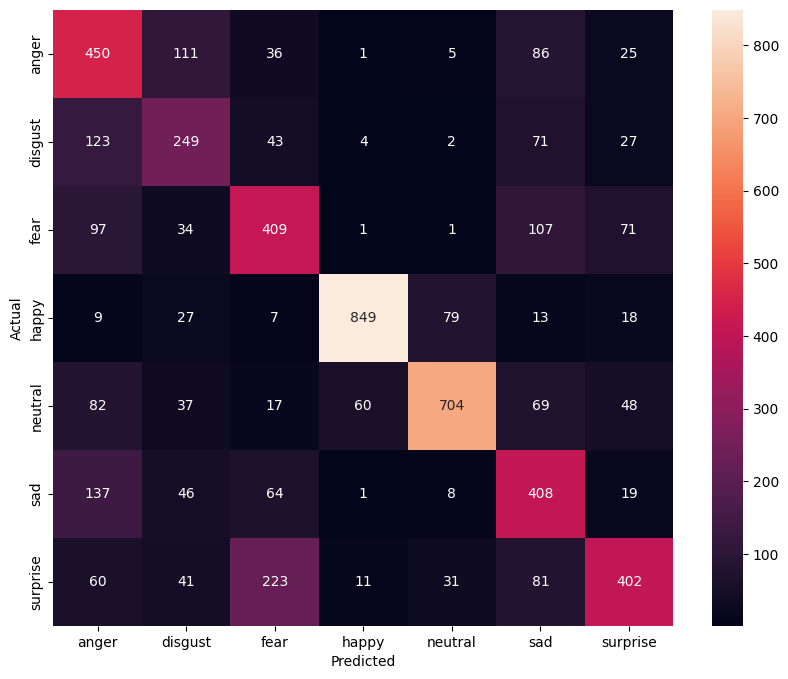

In [30]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [31]:
# model = load_model("C:\Users\darks\Downloads\model50VGG19.h5")

In [32]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [33]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


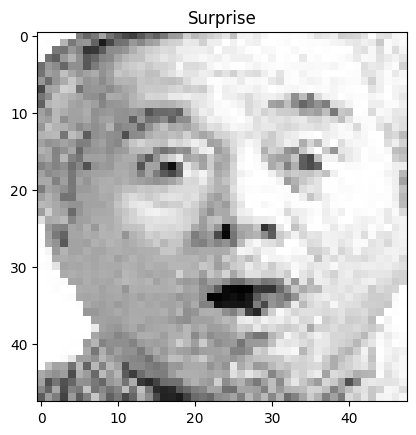

In [34]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 42ms/step
Accuracy =  0.625


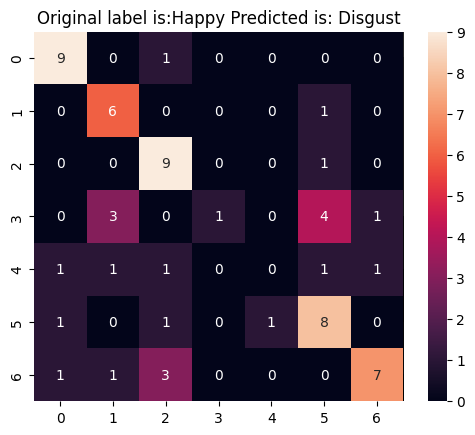

2/2 [==============================] - 0s 42ms/step
Accuracy =  0.3125


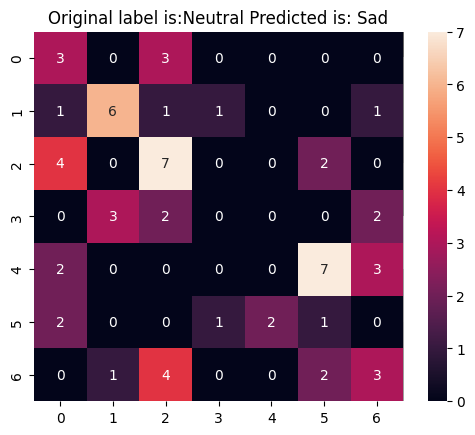

In [35]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [36]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.4404


In [37]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 43ms/step
Accuracy: 44.04296875
Angry 292/2100 acc: 68.5
Disgust 293/2100 acc: 59.7
Fear 294/2100 acc: 68.4
Happy 291/2100 acc: 14.4
Neutral 291/2100 acc: 0.7
Sad 293/2100 acc: 61.4
Surprise 294/2100 acc: 34.7


# Accuracy global and per class

In [38]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 44.04296875
Angry 292/2100 acc: 68.5
Disgust 293/2100 acc: 59.7
Fear 294/2100 acc: 68.4
Happy 291/2100 acc: 14.4
Neutral 291/2100 acc: 0.7
Sad 293/2100 acc: 61.4
Surprise 294/2100 acc: 34.7


              precision    recall  f1-score   support

       Angry       0.47      0.68      0.55       292
     Disgust       0.52      0.60      0.56       293
        Fear       0.43      0.68      0.53       294
       Happy       0.84      0.14      0.25       291
     Neutral       0.14      0.01      0.01       291
         Sad       0.38      0.61      0.47       293
    Surprise       0.36      0.35      0.35       294

    accuracy                           0.44      2048
   macro avg       0.45      0.44      0.39      2048
weighted avg       0.45      0.44      0.39      2048



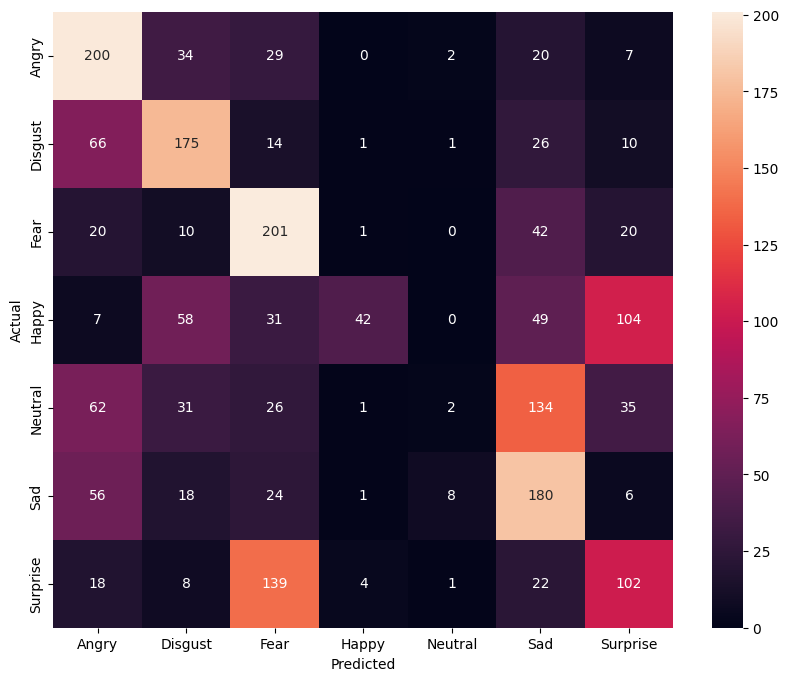

In [39]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test it with real images

In [59]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces4.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 2s 2s/step
Predicted emotion class: happy, probability: 0.9962181448936462
1/1 [==============================] - 0s 106ms/step
Predicted emotion class: fear, probability: 0.5953654646873474
1/1 [==============================] - 0s 114ms/step
Predicted emotion class: sad, probability: 0.631467342376709
1/1 [==============================] - 0s 103ms/step
Predicted emotion class: happy, probability: 0.45405980944633484
1/1 [==============================] - 0s 102ms/step
Predicted emotion class: sad, probability: 0.5255402326583862
1/1 [==============================] - 0s 98ms/step
Predicted emotion class: angry, probability: 0.4778483211994171
